<h3>Classification d'Images avec Data Augmentation (Random Erasing)<h3/>

In [300]:
###========================================================================
# Importations et Configuration
###========================================================================

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


# Configuration de l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil: {device}")

Utilisation de l'appareil: cpu


In [301]:
###========================================================================
# Transformation de Base (Normalisation)
###========================================================================

# Transformation de base : Redimensionnement, ToTensor, Normalisation
BASE_TRANSFORM = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Charger les données avec ImageFolder et la transformation de base
dataset = datasets.ImageFolder(root="data_img", transform=BASE_TRANSFORM)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True) #  nb_batch = nb_data / 32

print("Classes:", dataset.classes)
print("Index des classes:", dataset.class_to_idx)
print(len(dataset))

Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'ragno', 'sheep', 'squirrel']
Index des classes: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'ragno': 7, 'sheep': 8, 'squirrel': 9}
26179


In [ ]:
###========================================================================
# Sélection d'un Échantillon (Sous-échantillonnage)
###========================================================================

# --- Configuration ---
# Remplacez 'dataset' et 'data_loader' par vos objets PyTorch respectifs
# dataset = datasets.ImageFolder(root="data_img", transform=BASE_TRANSFORM) 
# data_loader = DataLoader(dataset, batch_size=32, shuffle=True) 

max_images_per_class = 2000 
num_classes = len(dataset.classes) # Nombre total de classes

# Dictionnaires pour stocker les images et labels
class_images = defaultdict(list)
class_labels = defaultdict(list)

print(f"Collecte de {max_images_per_class} images par classe...")

# --- Logique de Collecte Optimisée ---
# Utilise un ensemble (set) pour un look-up rapide
classes_to_collect = set(range(num_classes))
classes_finished = set()

for images, labels in data_loader:
    # Parcourir les images du lot
    for image, label in zip(images, labels):
        label_item = label.item()
        
        # Vérifier si on a déjà atteint la limite pour cette classe
        if label_item in classes_finished:
            continue
            
        # Ajouter l'image et le label
        class_images[label_item].append(image)
        class_labels[label_item].append(label_item)
        
        # Vérifier si la classe a atteint sa limite
        if len(class_images[label_item]) >= max_images_per_class:
            classes_finished.add(label_item)
            
    # Condition d'arrêt : Vérification après le lot
    if len(classes_finished) == num_classes:
        break

# --- Vérification Finale (Non nécessaire avec la logique ci-dessus, mais gardée par sécurité) ---
# S'assure que toutes les listes ne dépassent pas max_images_per_class
for class_idx in class_images:
    class_images[class_idx] = class_images[class_idx][:max_images_per_class]
    class_labels[class_idx] = class_labels[class_idx][:max_images_per_class]

# --- Affichage Final ---
print("\nNombre d'images par classe après sous-échantillonnage :")
for class_idx in sorted(class_images.keys()):
    count = len(class_images[class_idx])
    print(f"Classe {dataset.classes[class_idx]} : {count} images")

if len(classes_finished) < num_classes:
    print(f"\n Avertissement: Seulement {len(classes_finished)}/{num_classes} classes ont atteint {max_images_per_class} images (la fin du dataset a été atteinte).")

Collecte de 1000 images par classe...

Nombre d'images par classe après sous-échantillonnage :
Classe butterfly : 1000 images
Classe cat : 1000 images
Classe chicken : 1000 images
Classe cow : 1000 images
Classe dog : 1000 images
Classe elephant : 1000 images
Classe horse : 1000 images
Classe ragno : 1000 images
Classe sheep : 1000 images
Classe squirrel : 1000 images


In [332]:
# Définition des Datasets pour l'Augmentation
###========================================================================
# Classes de Dataset pour la Manipulation de Tenseurs
###========================================================================

class SubsetTensorDataset(Dataset):
    """Encapsule les tenseurs d'images collectés et normalisés."""
    def __init__(self, class_images, class_labels):
        self.images = []
        self.labels = []
        for label, images in class_images.items():
            self.images.extend(images)
            self.labels.extend([label] * len(images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class AugmentedSubset(Dataset):
    """Applique une transformation spécifique (e.g., RandomErasing) à un Subset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            # Application de la transformation (Random Erasing) sur le tenseur
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

<h3>Division train/test/valid et application des transformations<h3/>

In [333]:
###========================================================================
# Division et Application de Random Erasing
###========================================================================


# Créer le dataset de base avec les tenseurs collectés
base_dataset = SubsetTensorDataset(class_images, class_labels)
#base_dataset = dataset

# --- Paramètres de division ---

TRAIN_RATIO = 0.8
VALID_TEST_RATIO = 0.5 # 50% de la partie restante (20%) va à Valid et 50% à Test

total_size = len(base_dataset)
train_size = int(TRAIN_RATIO * total_size)
valid_test_size = total_size - train_size # Reste 20%

# 1. Division: Train et (Valid + Test)
train_indices, valid_test_indices = random_split(base_dataset, [train_size, valid_test_size])

# 2. Division: Valid et Test (à partir des 20% restants)
valid_size = int(VALID_TEST_RATIO * valid_test_size)
test_size = valid_test_size - valid_size # Assure que la somme est égale à valid_test_size

valid_indices, test_indices = random_split(valid_test_indices, [valid_size, test_size])



# --- Paramètres de la transformation ---

# Définition de Random Erasing (Suppression de zone)
# Il ne fait que la suppression de zone, car les autres étapes sont déjà faites.
RANDOM_ERASING_TRANSFORM = transforms.RandomErasing(
    p=1,           # 50% de chance d'appliquer la suppression
    scale=(0.02, 0.20), # Taille de la zone
    ratio=(0.3, 3),   # Ratio H/L
    value='random'   # Remplir la zone avec des valeurs aléatoires
)

# --- Création des Datasets et DataLoaders ---

# 1. Train Loader (AVEC Random Erasing)
train_dataset = AugmentedSubset(train_indices, transform=RANDOM_ERASING_TRANSFORM)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. Validation Loader (SANS augmentation)
valid_dataset = AugmentedSubset(valid_indices, transform=None)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 3. Test Loader (SANS augmentation)
test_dataset = AugmentedSubset(test_indices, transform=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Suppression des variables intermédiaires pour la clarté
del valid_test_indices

# 4. Train Loader (SANS augmentation)
# On utilise la classe AugmentedSubset, mais on passe transform=None
train_dataset_no_aug = AugmentedSubset(train_indices, transform=None) 
train_loader_no_aug = torch.utils.data.DataLoader(
    train_dataset_no_aug, 
    batch_size=32, 
    shuffle=True
)


# 3. Fusionner les deux datasets
# Le dataset final aura une taille double, contenant l'image A et l'image A augmentée.
combined_train_dataset = ConcatDataset([train_dataset, train_dataset_no_aug])

# 4. Créer un seul DataLoader
# Assurez-vous d'utiliser shuffle=True pour mélanger les lots augmentés et non augmentés.
combined_train_loader = torch.utils.data.DataLoader(
    combined_train_dataset, 
    batch_size=32, 
    shuffle=True
)

print(f"Tailles des ensembles : Train_combined={len(combined_train_dataset)}, Validation={valid_size}, Test={test_size}, Total={ total_size + len(combined_train_dataset)}")


Tailles des ensembles : Train_combined=16000, Validation=1000, Test=1000, Total=26000


In [330]:
print(f"train={len(train_dataset)}, Validation={valid_size}, Test={test_size}")

train=8000, Validation=1000, Test=1000


In [334]:
###========================================================================
# Visualisation de l'Augmentation
###========================================================================

# Définition de la fonction de dénormalisation (imshow)
def imshow(img, title=None):
    """Dé-normalise et affiche une image (tenseur PyTorch)"""
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    # Dé-normalisation
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1) 
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# ----------------------------------------------------------------------

def visualize_augmentation(base_dataset, transform_aug, class_id=None, image_index_in_class=None):
    """
    Visualise une image spécifique du jeu de données, avec et sans Random Erasing.

    Args:
        base_dataset (Dataset): Votre dataset initial (ImageFolder ou SubsetTensorDataset).
        transform_aug (torchvision.transforms.RandomErasing): La transformation d'augmentation à appliquer.
        class_id (int, optional): L'ID de la classe à visualiser.
        image_index_in_class (int, optional): L'index de l'image DANS cette classe.
    """
    
    # 1. Préparation des indices optimisée
    class_indices = defaultdict(list)
    
    if isinstance(base_dataset, ImageFolder):
        # 🔑 OPTIMISATION pour ImageFolder : Utiliser les attributs internes
        # base_dataset.targets contient la liste de tous les labels (index)
        for idx, label in enumerate(base_dataset.targets):
            class_indices[label].append(idx)
    elif hasattr(base_dataset, 'labels'):
         # Optimisation pour la classe SubsetTensorDataset
        for idx, label in enumerate(base_dataset.labels):
            class_indices[label].append(idx)
    else:
        # Solution lente de secours pour les autres types de Dataset
        print("Avertissement: Utilisation d'une boucle lente pour la recherche d'indices.")
        for idx, (img, label) in enumerate(base_dataset):
            class_indices[label].append(idx)

    # 2. Sélection de la classe et de l'index (Le reste de la logique de sélection est conservé)
    
    if not class_indices:
        print("Aucune image trouvée dans le dataset.")
        return

    if class_id is None:
        class_id = random.choice(list(class_indices.keys()))
    
    if class_id not in class_indices:
        print(f"La classe {class_id} n'a pas été trouvée dans le base_dataset.")
        return

    if image_index_in_class is None:
        image_index_in_class = random.randrange(len(class_indices[class_id]))

    try:
        global_index = class_indices[class_id][image_index_in_class]
    except IndexError:
        print(f"L'indice {image_index_in_class} est hors limites pour la classe {class_id} (max {len(class_indices[class_id])-1}).")
        return

    # 3. Extraction et Augmentation
    
    # L'accès à base_dataset[global_index] lit et transforme l'image UNE SEULE FOIS.
    image_orig, label_idx = base_dataset[global_index]
    
    # Appliquer manuellement la transformation d'augmentation
    image_aug = transform_aug(image_orig.clone())

    # 4. Affichage
    
    # Si base_dataset est ImageFolder, il a l'attribut .classes
    if hasattr(base_dataset, 'classes'):
        class_name = base_dataset.classes[label_idx]
    else:
        # Utiliser l'ancienne logique si le nom des classes n'est pas directement accessible
        class_name = f"Classe {label_idx}"
    
    print(f"Visualisation de l'image [Local: {image_index_in_class}, Global: {global_index}] de la classe '{class_name}':")

    # Nom de la transformation appliquée
    transform_name = transform_aug.__class__.__name__  # Récupère le nom de la classe de la transformation
    
    # Créez le titre avec le nom de la transformation
    original_title = f"Original - {class_name}"
    augmented_title = f"Augmentée ({transform_name}) - {class_name}"

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    plt.sca(axes[0])
    imshow(image_orig.cpu(), title=original_title)
    plt.sca(axes[1])
    imshow(image_aug.cpu(), title=augmented_title)
    plt.tight_layout()
    plt.show()


--- 1. Exemple Aléatoire ---
Visualisation de l'image [Local: 1551, Global: 8429] de la classe 'cow':


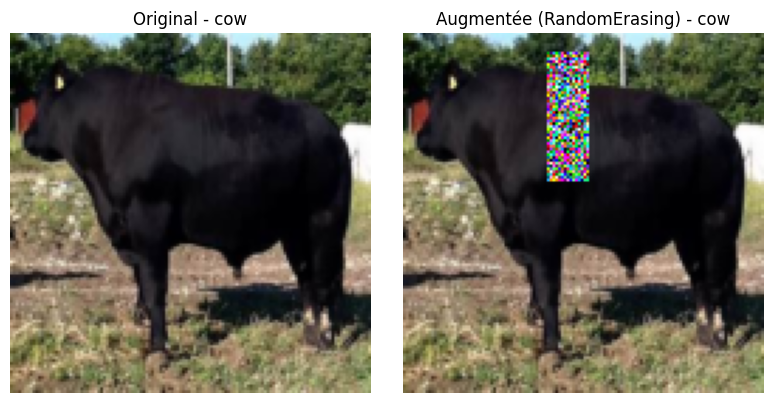

Visualisation de l'image [Local: 2, Global: 2] de la classe 'butterfly':


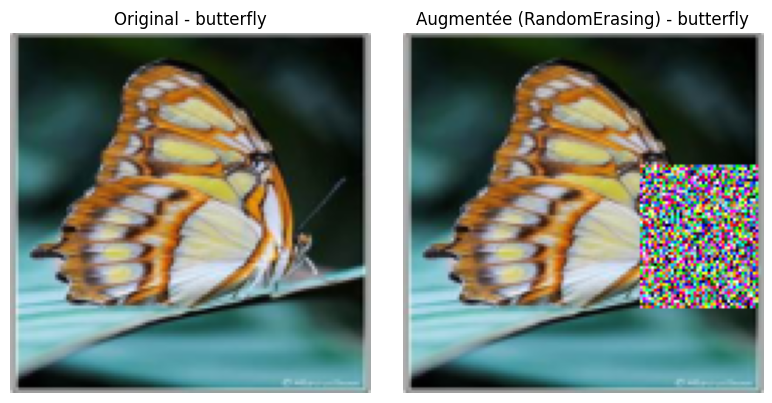

In [336]:
# --- APPEL ---

# 1. Sélection Aléatoire (par défaut)
print("--- 1. Exemple Aléatoire ---")
visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM) 

# 2. Sélection Spécifique (Classe 0, 3e image)
visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM, class_id=0, image_index_in_class=2)

In [314]:
###========================================================================
# Définition du Modèle 
###========================================================================

class CNN_Animals(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Taille d'entrée pour la FC: 128x128 -> (pool x3) -> 16x16
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNN_Animals(num_classes=len(dataset.classes)).to(device)
print(model)

CNN_Animals(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [337]:
# Modèle CNN et Fonctions d'Entraînement/Test
###========================================================================
# Boucles d'Entraînement et de Test
###========================================================================

def train_loop(loader, model, loss_fn, optimizer, log=True):
    model.train()
    total_loss = 0
    size = len(loader.dataset)

    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)

        # Forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if log and batch % 10 == 0:
            current = (batch + 1) * len(X)
            # batch_size_actual = len(X) # Taille réelle du lot # [Taille lot: {batch_size_actual:>2d}]
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
            

    avg_loss = total_loss / len(loader)
    print(f"🔹 Moyenne de la loss sur l'époque : {avg_loss:.4f}")
    return avg_loss

def test_loop(loader, model, loss_fn, log=True):
    model.eval()
    size = len(loader.dataset)
    num_batches = len(loader)
    test_loss, correct = 0, 0

    # Listes pour collecter toutes les prédictions et tous les labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # Collecte des prédictions et des labels
            predictions = pred.argmax(1)
            correct += (predictions == y).type(torch.float).sum().item()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    accuracy = correct / size

    # Calcul des métriques avancées avec scikit-learn
    
    # Le mode 'macro' traite toutes les classes avec le même poids (utile pour les classes déséquilibrées)
    # Le mode 'weighted' pondère les scores par le nombre d'échantillons de chaque classe
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    # Génération de la Matrice de Confusion
    conf_matrix = confusion_matrix(all_labels, all_preds)

    if log:
        print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, loss: {test_loss:>8f} ")
        print("-" * 30)
        print(f"Metrics (Macro Avg.):")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print("-" * 30)
        # Vous pouvez aussi afficher la matrice de confusion à la fin de l'entraînement
        # print("Matrice de Confusion:\n", conf_matrix)
        
    # Retourne la loss, l'accuracy et le score F1 macro
    return test_loss, 100 * accuracy, f1

In [ ]:
# --- Fonction pour résumer les résultats ---
def res(loss_tr_, loss_t, acc_t, f1_t):
    print("Train Loss    ", "Init: ", loss_tr_[0], "           Final: ", loss_tr_[len(loss_t)-1])
    print("Valid Loss    ", "Init: ", loss_t[0], "           Final: ", loss_t[len(loss_t)-1])
    print("Accuracy", "Init: ", acc_t[0], "           Final: ", acc_t[len(acc_t)-1], "%")
    print("F1 Score", "Init: ", f1_t[0], "         Final: ", f1_t[len(f1_t)-1])

def res_t(loss_t, acc_t, f1_t):
    print("Test Loss", loss_t)
    print("Test Accuracy", acc_t, "%")
    print("F1 Score", f1_t)


# --- Fonction pour tracer les courbes ---
def plot_res(loss_tr_, loss_t, acc_t, f1_t, g=F) : 
    # Tracé des courbes (utilisant les données de VALIDATION)
    plt.figure(figsize=(18, 5))

    
    # 1. Courbe de Perte et Accuracy sur le même graphique si F == 'T'
    if g == 'T':
        plt.subplot(1, 3, 1)
        plt.plot(loss_tr_, label='Train Loss', color='red')
        plt.plot(loss_t, label='Validation Loss', color='blue')
        plt.plot(acc_t, label='Validation Accuracy', color='green')
        plt.title('Courbes de Perte et Accuracy')
        plt.xlabel('Époque')
        plt.ylabel('Loss / Accuracy')
        plt.legend()
        plt.grid(True)
    else :
        # Si g != 'T', afficher perte et accuracy sur des graphes séparés
        # Courbe de Perte
        plt.subplot(1, 3, 1)
        plt.plot(loss_tr_, label='Train Loss')
        plt.plot(loss_t, label='Validation Loss')
        plt.title('Courbe de Perte')
        plt.xlabel('Époque')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # 2. Courbe d'Accuracy
        plt.subplot(1, 3, 2)
        plt.plot(acc_t, label='Validation Accuracy', color='green')
        plt.title("Courbe d'Accuracy")
        plt.xlabel('Époque')
        plt.ylabel('Précision (%)')
        plt.legend()
        plt.grid(True)


    # 3. Courbe du F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(f1_t, label='Validation F1 Score', color='purple')
    plt.title('Courbe du F1 Score')
    plt.xlabel('Époque')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [340]:
###========================================================================
# Entraînement Final données augmentées
###========================================================================

epochs = 7
loss_test_ = []
loss_train_ = []
acc_valid_ = []
f1_valid_ = []

if 'model' in locals():
    del model
    print("model supp")


model = CNN_Animals(num_classes=len(dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for t in range(epochs):
    print(f"\n===== Époque {t+1} =====")
    # Entraînement avec data augmentation
    loss_train_.append(train_loop(combined_train_loader, model, loss_fn, optimizer))
    # Évaluation sans data augmentation (loss, accuracy, f1_score)
    l_, a_, f_ = test_loop(valid_loader, model, loss_fn) 
    loss_test_.append(l_) # Loss de Validation
    acc_valid_.append(a_) # Accuracy de Validation
    f1_valid_.append(f_)  # F1 Score de Validation

print("Done!")

res(loss_train_, loss_test_, acc_valid_, f1_valid_)

model supp

===== Époque 1 =====
loss: 2.299461  [   32/16000]
loss: 2.307487  [  352/16000]
loss: 2.284211  [  672/16000]
loss: 2.295213  [  992/16000]
loss: 2.308077  [ 1312/16000]
loss: 2.300765  [ 1632/16000]
loss: 2.311604  [ 1952/16000]
loss: 2.285658  [ 2272/16000]
loss: 2.311594  [ 2592/16000]
loss: 2.314565  [ 2912/16000]
loss: 2.294358  [ 3232/16000]
loss: 2.308003  [ 3552/16000]
loss: 2.305246  [ 3872/16000]
loss: 2.303481  [ 4192/16000]
loss: 2.292351  [ 4512/16000]
loss: 2.296072  [ 4832/16000]
loss: 2.300681  [ 5152/16000]
loss: 2.277458  [ 5472/16000]
loss: 2.302868  [ 5792/16000]
loss: 2.298307  [ 6112/16000]
loss: 2.307294  [ 6432/16000]
loss: 2.271977  [ 6752/16000]
loss: 2.288117  [ 7072/16000]
loss: 2.288644  [ 7392/16000]
loss: 2.281859  [ 7712/16000]
loss: 2.290532  [ 8032/16000]
loss: 2.287349  [ 8352/16000]
loss: 2.279485  [ 8672/16000]
loss: 2.268565  [ 8992/16000]
loss: 2.291936  [ 9312/16000]
loss: 2.283617  [ 9632/16000]
loss: 2.295157  [ 9952/16000]
loss: 2

In [341]:
res(loss_train_, loss_test_, acc_valid_, f1_valid_)

Train Loss     Init:  2.275717730522156            Final:  1.527741732597351
Valid Loss     Init:  2.191553547978401            Final:  1.6789168268442154
Accuracy Init:  19.6            Final:  41.699999999999996 %
F1 Score Init:  0.1289487297503281          Final:  0.4139190220748764


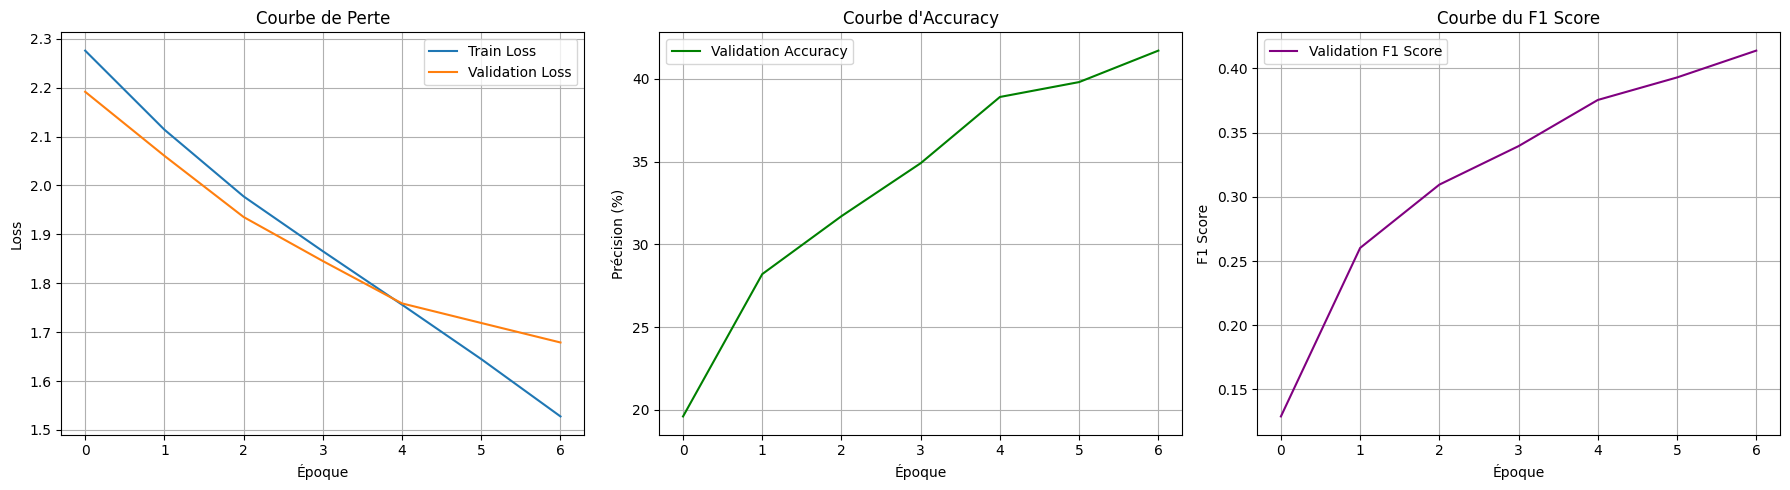

In [342]:
plot_res(loss_train_, loss_test_, acc_valid_, f1_valid_)

<h3>Évaluation Finale sur le jeu de donnée Test <h3/>

In [343]:
print("\n" + "="*50)
print(" Évaluation Finale sur l'ENSEMBLE de TEST ")
print("="*50)

# Utilisation du test_loader pour l'évaluation finale
test_loss_final, test_acc_final, test_f1_final = test_loop(test_loader, model, loss_fn, log=True)

def res_t(test_loss_final, test_acc_final, test_f1_final):
    print(f"\nRESULTATS FINAUX SUR LE JEU DE TEST ({test_size} échantillons) :")
    print(f"  - Perte (Loss): {test_loss_final:.4f}")
    print(f"  - Précision (Accuracy): {test_acc_final:.1f}%")
    print(f"  - F1 Score (Macro): {test_f1_final:.4f}")

res_t(test_loss_final, test_acc_final, test_f1_final)


 Évaluation Finale sur l'ENSEMBLE de TEST 
Test Error: 
 Accuracy: 42.3%, loss: 1.630593 
------------------------------
Metrics (Macro Avg.):
  Precision: 0.4479
  Recall:    0.4258
  F1 Score:  0.4172
------------------------------

RESULTATS FINAUX SUR LE JEU DE TEST (1000 échantillons) :
  - Perte (Loss): 1.6306
  - Précision (Accuracy): 42.3%
  - F1 Score (Macro): 0.4172


In [ ]:
#res()

Loss     Init:  1.407906849936741            Final:  1.184133826959424
Accuracy Init:  52.67379679144385            Final:  66.88311688311688 %
F1 Score Init:  0.49144431521290544          Final:  0.6413191852986884


<h3> Entraînement sans Augmentation <h3/>

In [344]:
###========================================================================
# Entraînement Final sans augmentation
###========================================================================

epochs = 7
loss_test = []
loss_train = []
acc_valid = []
f1_valid = []

if 'model' in locals():
    del model
    print("model supp")


model = CNN_Animals(num_classes=len(dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for t in range(epochs):
    print(f"\n--- Époque {t+1} (SANS Augmentation) ---")
    # Entraînement avec data augmentation
    loss_train.append(train_loop(train_loader_no_aug, model, loss_fn, optimizer))
    # Évaluation sans data augmentation (loss, accuracy, f1_score)
    l, a, f = test_loop(valid_loader, model, loss_fn) 
    loss_test.append(l)
    acc_valid.append(a)
    f1_valid.append(f)
print("Done!")

res(loss_train, loss_test, acc_valid, f1_valid)

model supp

--- Époque 1 (SANS Augmentation) ---
loss: 2.297351  [   32/ 8000]
loss: 2.306742  [  352/ 8000]
loss: 2.302132  [  672/ 8000]
loss: 2.294248  [  992/ 8000]
loss: 2.294833  [ 1312/ 8000]
loss: 2.297821  [ 1632/ 8000]
loss: 2.289216  [ 1952/ 8000]
loss: 2.292911  [ 2272/ 8000]
loss: 2.298525  [ 2592/ 8000]
loss: 2.300373  [ 2912/ 8000]
loss: 2.305730  [ 3232/ 8000]
loss: 2.300053  [ 3552/ 8000]
loss: 2.287875  [ 3872/ 8000]
loss: 2.285520  [ 4192/ 8000]
loss: 2.307492  [ 4512/ 8000]
loss: 2.291404  [ 4832/ 8000]
loss: 2.303234  [ 5152/ 8000]
loss: 2.306900  [ 5472/ 8000]
loss: 2.297207  [ 5792/ 8000]
loss: 2.290770  [ 6112/ 8000]
loss: 2.312962  [ 6432/ 8000]
loss: 2.282505  [ 6752/ 8000]
loss: 2.269121  [ 7072/ 8000]
loss: 2.285666  [ 7392/ 8000]
loss: 2.284870  [ 7712/ 8000]
🔹 Moyenne de la loss sur l'époque : 2.2967
Test Error: 
 Accuracy: 16.2%, loss: 2.284832 
------------------------------
Metrics (Macro Avg.):
  Precision: 0.2544
  Recall:    0.1649
  F1 Score:  0.112

In [345]:
res(loss_train, loss_test, acc_valid, f1_valid)

Train Loss     Init:  2.2966947898864745            Final:  1.8033801832199097
Valid Loss     Init:  2.2848321050405502            Final:  1.8036219142377377
Accuracy Init:  16.2            Final:  37.1 %
F1 Score Init:  0.11207434244589767          Final:  0.35692654580909344


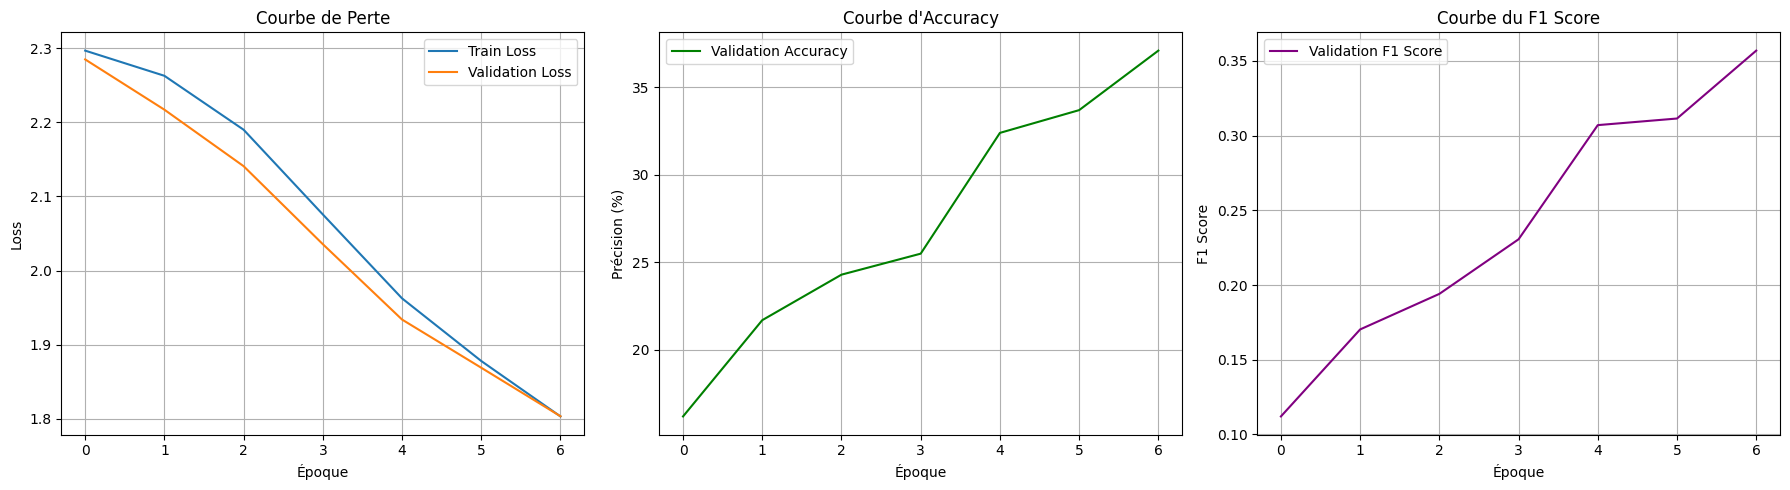

In [346]:
###========================================================================
# Tracé des Résultats
###========================================================================

# Tracé des courbes
plot_res(loss_train, loss_test, acc_valid, f1_valid)

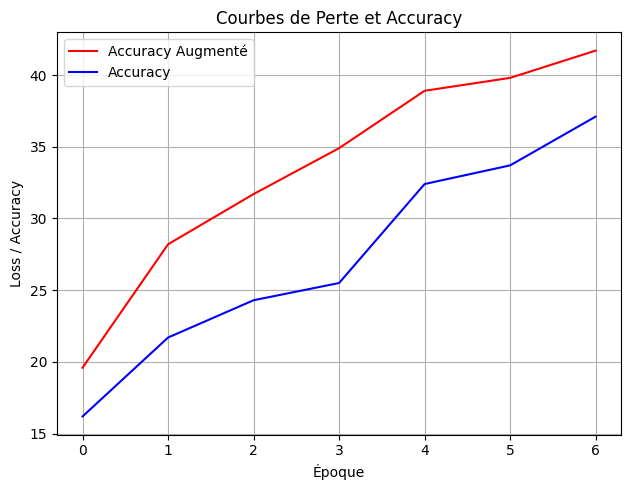

Accuracy aug max    : 41.699999999999996
Accuracy no aug max : 37.1


In [349]:
def plot_res_c(acc_t_1, acc_t_2) : 
    # Tracé des courbes (utilisant les données de VALIDATION)
    plt.figure(figsize=(18, 5))

    # 1. Courbe Accuracy sur le même graphique 
    plt.subplot(1, 3, 1)
    plt.plot(acc_t_1, label='Accuracy Augmenté', color='red')
    plt.plot(acc_t_2, label='Accuracy', color='blue')
    plt.title('Courbes de Perte et Accuracy')
    plt.xlabel('Époque')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_res_c(acc_valid_, acc_valid) 

print("Accuracy aug max    :", max(acc_valid_))
print("Accuracy no aug max :", max(acc_valid))


<p> Sans augmentation learn y = 1e-3 ; adam <p/>
<p> Loss     Init:  1.3512092952321215            Final:  1.014780085988161 <p/>
<p> Accuracy Init:  53.7433155080214            Final:  67.3414820473644 % <p/>
<p> F1 Score Init:  0.49264617865110233          Final:  0.642271303218783 <p/>
<p> nb epoch opt = 4 pour la valid loss et 2 pour accuracy et F1 score <p/>


<p> Sans augmentation learn y = 1e-4 ; adam <p/>
<p> Loss     Init:  1.7326274019915884            Final:  1.3378207218356248 <p/>
<p> Accuracy Init:  39.49579831932773            Final:  54.736440030557674 % <p/>
<p> F1 Score Init:  0.30294142585012596          Final:  0.49925118199103957 <p/>
<p> nb epoch opt = 4 pour la valid loss et 2 pour accuracy et F1 score <p/>

In [185]:
import torch
import random
from torch.nn.modules.module import Module

class PatchShuffle(Module):
    """
    Applique la régularisation PatchShuffle : Permet aléatoirement les pixels 
    dans une fenêtre glissante de taille n x n.
    """
    def __init__(self, patch_size=3, p=0.5):
        super().__init__()
        self.patch_size = patch_size
        self.p = p # Probabilité d'appliquer la transformation

    def forward(self, img):
        if torch.rand(1).item() < self.p:
            C, H, W = img.shape
            n = self.patch_size
            
            # 1. Parcourir l'image par pas de taille de patch
            # On utilise les boucles 'range' pour définir les coins supérieurs gauches des patches
            for i in range(0, H - n + 1, n):
                for j in range(0, W - n + 1, n):
                    # 2. Extraire le patch actuel (forme : C, n, n)
                    patch = img[:, i:i+n, j:j+n]
                    
                    # 3. Mettre le patch à plat (forme : C, n*n)
                    # Le torch.permute est nécessaire pour s'assurer que C reste la première dimension
                    patch_flat = patch.reshape(C, n * n)
                    
                    # 4. Générer l'ordre de permutation aléatoire
                    # L'ordre doit être le même pour tous les canaux C
                    indices = torch.randperm(n * n)
                    
                    # 5. Appliquer la permutation (mélange des pixels)
                    # On permute uniquement sur la dimension des pixels (dim=1)
                    patch_shuffled_flat = patch_flat[:, indices]
                    
                    # 6. Remettre le patch en forme 3D et le replacer dans l'image
                    patch_shuffled = patch_shuffled_flat.reshape(C, n, n)
                    img[:, i:i+n, j:j+n] = patch_shuffled
                    
            return img
        return img

In [297]:
import torchvision.transforms as transforms

# --- Définition de la transformation translation RandomAffine ---
TRANSLATION_TRANSFORM = transforms.RandomAffine(
    degrees=0,               # Pas de rotation
    translate=(0.3, 0.3),    # Décalage max de 10% en horizontal et vertical
    fill=0                   # Remplir les zones vides avec du noir
)

# --- Définition de la transformation RandomErasing ---
RANDOM_ERASING_TRANSFORM_SP_B = transforms.RandomErasing(
    p=1,           # 50% de chance d'appliquer la suppression
    scale=(0.02, 0.33), # Taille de la zone
    ratio=(0.3, 3.3),   # Ratio H/L
    value=0   # Remplir la zone avec des valeurs aléatoires
)
# --- Définition de la transformation RandomErasing ---
RANDOM_ERASING_TRANSFORM_SP_W = transforms.RandomErasing(
    p=1,           # 50% de chance d'appliquer la suppression
    scale=(0.02, 0.33), # Taille de la zone
    ratio=(0.3, 3.3),   # Ratio H/L
    value=255   # Remplir la zone avec des valeurs aléatoires
)

# --- Définition de la transformation Filtre Flou Gaussien ---
GAUSSIAN_BLUR_TRANSFORM = transforms.GaussianBlur(
    kernel_size=5, # Taille du noyau (doit être un entier impair, e.g., 3, 5, 7...)
    sigma=(0.1, 2.0) # Écart-type du noyau (sigma)
    # L'écart-type est choisi uniformément entre 0.1 et 2.0 pour l'augmentation
)

# --- Définition de la transformation Filtre Netteté ---
SHARPNESS_TRANSFORM = transforms.RandomAdjustSharpness(
    sharpness_factor=2.0, # Facteur d'ajustement de la netteté (1.0 = aucune modification)
    p=1 # 50% de chance d'appliquer la transformation
)

# --- Définition de la transformation PatchShuffle ---
PATCH_SHUFFLE_TRANSFORM = PatchShuffle(
    patch_size=3, # Fenêtre 3x3 (ou choisissez 5, 7, etc.)
    p=0.6        # 60% de chance d'appliquer la permutation
)

COLOR_JITTER_TRANSFORM = transforms.ColorJitter(
    brightness=0.2,  # Variation aléatoire de la luminosité (max +/- 20% du niveau actuel)
    contrast=0.2,    # Variation aléatoire du contraste (max +/- 20%)
    saturation=0.2,  # Variation aléatoire de la saturation (max +/- 20%)
    hue=0.1          # Variation aléatoire de la teinte (max +/- 10% de la plage -0.5 à 0.5)
)


# Convertit aléatoirement l'image en niveaux de gris avec une probabilité p
RANDOM_GRAYSCALE_TRANSFORM = transforms.RandomGrayscale(
    p=1 # 50% de chance de convertir l'image en niveaux de gris
)

Visualisation de l'image [Local: 365, Global: 22862] de la classe 'sheep':


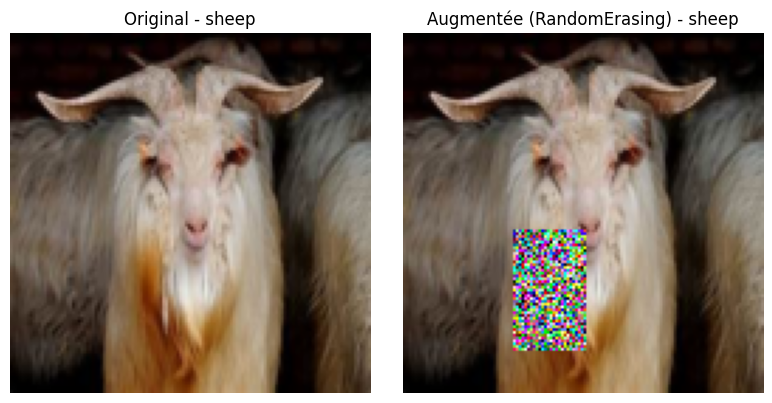

Visualisation de l'image [Local: 746, Global: 23243] de la classe 'sheep':


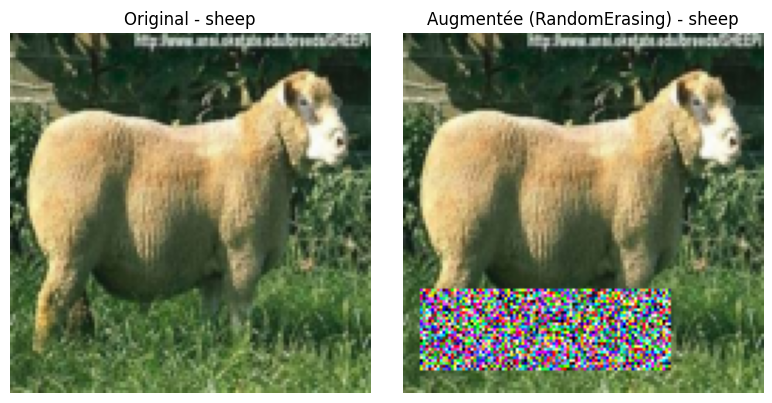

In [367]:
for i in range(2):
    visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM, class_id=8)
#visualize_augmentation(dataset, SHARPNESS_TRANSFORM, class_id=2, image_index_in_class=9)
#visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM_SP_B, class_id=1, image_index_in_class=19)
#visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM_SP_B, class_id=6, image_index_in_class=19)
#visualize_augmentation(dataset, RANDOM_ERASING_TRANSFORM_SP_W, class_id=0, image_index_in_class=2)
#visualize_augmentation(dataset, RANDOM_GRAYSCALE_TRANSFORM, class_id=0, image_index_in_class=2)
#visualize_augmentation(dataset, PATCH_SHUFFLE_TRANSFORM, class_id=6)